In [1]:
%load_ext autoreload
%autoreload 2

import banner

topics = ['Convolutional Neural Networks in Pytorch',
          'ConvNet2d Class',
          'Try it on MNIST',
          'Compare Time on CPU vs GPU',
          'Now let\'s look at the weights and outputs of convolutional layers']

banner.reset(topics)



Topics in this Notebook

1. Convolutional Neural Networks in Pytorch
2. ConvNet2d Class
3. Try it on MNIST
4. Compare Time on CPU vs GPU
5. Now let's look at the weights and outputs of convolutional layers


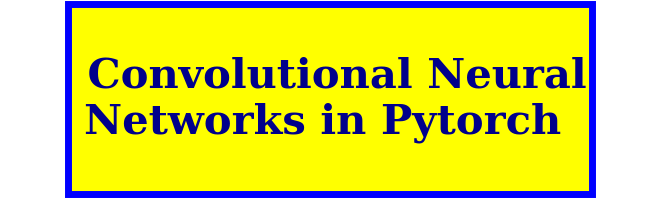

In [81]:
banner.next_topic()

# Convolutional Neural Networks in Pytorch


In [2]:
import numpy as np

import torch
print(torch.__version__)

import time

import gzip
import pickle

import matplotlib.pyplot as plt

2.4.0.post300


Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet2d(input_shape=(1, 28, 28), 
                     conv_specs=[(20, 4, 1), (10, 3, 2)],
                     fc_specs=[20],
                     n_outputs = 10,
                     device='cpu')               
```
`conv_specs` has a sublist for each convolutional layer, specifying `(n_units, kernel_size, stride)`.

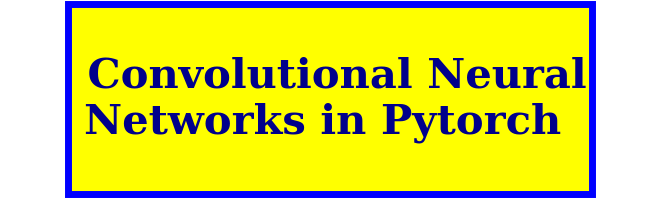

In [3]:
banner.next_topic()

# `ConvNet2d` class

In [4]:
%%writefile convnet2d.py
import numpy as np
import torch

class ConvNet2d(torch.nn.Module):
    
    def __init__(self, input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device='cpu'):
        '''Example for MNIST:
        ConvNet2D((1, 28, 28), [(20, 3, 1), (10, 4, 2)], [20], 'tanh', 'cuda')
        '''

        super().__init__()
        
        self.input_shape = input_shape
        self.device = device
        print('ConvNet: Using device', self.device)
        self.activation_function = torch.nn.Tanh() if activation_function == 'tanh' else torch.nn.ReLU()
        
        # Create all convolutional layers
        n_in = input_shape[0]
        # input_hw = input_shape[1]
        self.conv_layers = torch.nn.Sequential()
        for nh, patch_size, stride in conv_specs:
            self.conv_layers.append( torch.nn.Sequential( torch.nn.Conv2d(n_in, nh, patch_size, stride),
                                                          self.activation_function) )
            n_in = nh
            # Calculate number of outputs of convolutional layers
            # conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            # input_hw = conv_layer_output_hw  # for next trip through this loop

        # Or we pass some zero input samples through the conv_layers and see how many values result
        z = self.conv_layers(torch.zeros([1] + list(input_shape)))
        z = z.reshape(1, -1)
        n_in = z.shape[1]
        
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        # n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.Sequential()
        for nh in fc_specs:
            self.fc_layers.append( torch.nn.Sequential( torch.nn.Linear(n_in, nh),
                                                        self.activation_function) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        # Notice, no softmax function applied here.  It is internal to torch.nn.CrossEntropyLoss!
        self.fc_layers.append(output_layer)
        
        self.Xmeans = None
        self.pc_trace = []
        self.best_pc_val = None
        self.to(self.device)

    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Zs = [X]
        for conv_layer in self.conv_layers:
            Zs.append( conv_layer(Zs[-1]) )

        # Flatten outputs from last convolutional layer.
        Zs[-1] = Zs[-1].reshape(n_samples, -1)
        for fc_layer in self.fc_layers:
            Zs.append( fc_layer(Zs[-1]) )

        return Zs
    
    def forward(self, X, keep_all_outputs=False):
        if not isinstance(X, torch.Tensor):
            X = self._X_as_torch(X)
        Zs = self._forward_all_outputs(X)
        
        if keep_all_outputs:
            self.Zs = Zs
            
        return Zs[-1]
    
    def _X_as_torch(self, X):
        if isinstance(X, torch.Tensor):
            return X
        else:
            return torch.from_numpy(X.reshape([-1] + list(self.input_shape)).astype(np.float32)).to(self.device)

    def _T_as_torch(self, T):
        if isinstance(T, torch.Tensor):
            return T
        else:
            return torch.from_numpy(T.astype(np.int64)).to(self.device)

    def percent_correct(self, Yclasses, T):
        if isinstance(T, torch.Tensor):
            return (Yclasses == T).float().mean().item() * 100
        else:
            return (Yclasses == T).mean().item() * 100
    
    def train(self, Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method='sgd', learning_rate=0.01, verbose=True):
        
        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        if self.Xmeans is None:
            self.Xmeans = Xtrain.mean(0)
            self.Xstds = Xtrain.std(0)
            
        XtrainS = (Xtrain - self.Xmeans) / self.Xstds

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss()
        # loss_f = torch.nn.NLLLoss()
        
        if batch_size == -1:
            batch_size = Xtrain.shape[0]

        self.batch_size = batch_size  # remember this for use in forward functions

        for epoch in range(n_epochs):

            for first in range(0, Xtrains.shape[0], batch_size):
                Xtrain_batch = Xtrains[first:first + batch_size]
                Ttrain_batch = Ttrain[first:first + batch_size]

                # Set data matrices to torch.tensors if not already.
                Xtrain_batch = self._X_as_torch(Xtrain_batch)
                Ttrain_batch = self._T_as_torch(Ttrain_batch)

                Y = self(Xtrain_batch)
                loss = loss_f(Y, Ttrain_batch)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                pc_train = self.percent_correct(self.use(Xtrain), Ttrain)
                pc_val = self.percent_correct(self.use(Xval), Tval)
                self.pc_trace.append([pc_train, pc_val])

                if self.best_pc_val is None or pc_val > self.best_pc_val:
                    self.best_pc_val = pc_val
                    self.best_epoch = epoch + 1
                    # Save weights to be restored when done training
                    self.best_parameters = [p.clone() for p in self.parameters()]

            if verbose and (epoch + 1) % max(1, (n_epochs // 10)) == 0:
                print(f'{method} Epoch {epoch + 1} % Correct: Train {self.pc_trace[-1][0]:.1f}'
                      f' Val {self.pc_trace[-1][1]:.1f}')

        # Restore weights that resulted in best_pc_val
        for p, bestp in zip(self.parameters(), self.best_parameters):
            p.data = bestp.clone()

        return self

    def _softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X, return_probs=False, keep_all_outputs=False):
        
        classes = []
        probs = []
        return_numpy = False
        
        X = (X - self.Xmeans) / self.Xstds

        for first in range(0, X.shape[0], self.batch_size):
            X_batch = X[first:first + self.batch_size]

            if not isinstance(X_batch, torch.Tensor):
                X_batch = self._X_as_torch(X_batch)
                return_numpy = True

            with torch.no_grad():
                
                Y = self(X_batch, keep_all_outputs=keep_all_outputs)
                class_index = torch.argmax(Y, axis=1).cpu().numpy()
                classes.extend(self.classes[class_index])
                
                if return_probs:
                    probs.extend(self._softmax(Y).cpu().numpy())
                
        if return_numpy:
            classes = np.array(classes) # .cpu().numpy()
            probs = np.array(probs) # .cpu().numpy()
                    
        if return_probs:
            return classes, probs
        else:
            return classes

Overwriting convnet2d.py


In [5]:
import platform

node = platform.node()

if torch.cuda.is_available():
    print(f'{node} has an available cuda GPU.')
    
if torch.backends.mps.is_available():
    print(f'{node} has an available mps GPU.')
    
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# device = 'cpu'

print('Using device', device)

farley has an available cuda GPU.
Using device cuda


In [6]:
!nvidia-smi

Tue Nov  5 12:08:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:02:00.0 Off |                  N/A |
|  0%   45C    P8             21W /  350W |     380MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

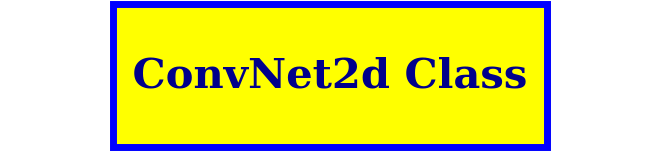

In [7]:
banner.next_topic()

# Try it on MNIST

In [8]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1] 
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1] 

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

In [9]:
import convnet2d as cnn

ConvNet: Using device cuda
adam Epoch 10 % Correct: Train 89.8 Val 91.0
adam Epoch 20 % Correct: Train 93.9 Val 94.4
adam Epoch 30 % Correct: Train 96.5 Val 96.7
adam Epoch 40 % Correct: Train 97.6 Val 97.5
adam Epoch 50 % Correct: Train 98.2 Val 97.8
adam Epoch 60 % Correct: Train 98.6 Val 98.0
adam Epoch 70 % Correct: Train 98.9 Val 98.2
adam Epoch 80 % Correct: Train 99.2 Val 98.3
adam Epoch 90 % Correct: Train 99.3 Val 98.4
adam Epoch 100 % Correct: Train 99.5 Val 98.4
% Correct Test 98.3


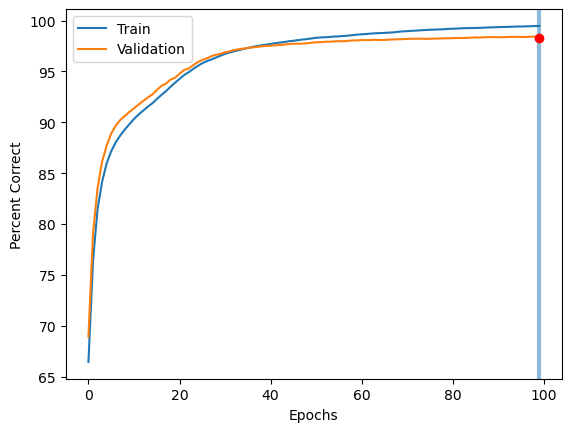

In [10]:
input_shape = (1, 28, 28)
n_outputs = 10

conv_specs = [(40, 4, 1), (10, 3, 2)]
fc_specs = [20]

#batch_size = -1  # means all training samples used in a single batch
batch_size = 5000
n_epochs = 100
device = 'cuda'

nnet = cnn.ConvNet2d(input_shape, conv_specs, fc_specs, n_outputs, 
                 activation_function='tanh', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method='adam', 
           learning_rate=0.001, verbose=True)

pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)
print(f'% Correct Test {pc_test:.1f}')

plt.plot(nnet.pc_trace)
plt.axvline(nnet.best_epoch, lw=3, alpha=0.5)
plt.plot(nnet.best_epoch, pc_test, 'ro')
plt.xlabel('Epochs')
plt.ylabel('Percent Correct')
plt.legend(('Train', 'Validation'));

Let's compare compute time for training our ConvNet2D on a GPU versus a CPU.

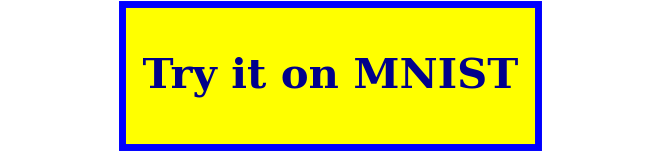

In [11]:
banner.next_topic()

# Compare Times on CPU vs GPU

In [76]:
n_epochs = 100

device = 'cpu'
start_time = time.time()
nnet = cnn.ConvNet2d(input_shape, conv_specs, fc_specs, n_outputs, 
                 activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method='adam', 
           learning_rate=0.001, verbose=True)
cpu_elapsed_time = time.time() - start_time


device = 'cuda'
start_time = time.time()
nnet = cnn.ConvNet2d(input_shape, conv_specs, fc_specs, n_outputs, 
                 activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method='adam', 
           learning_rate=0.001, verbose=True)
gpu_elapsed_time = time.time() - start_time

print(f'Execution time in minutes: cpu {cpu_elapsed_time/60:.2f} gpu {gpu_elapsed_time/60:.2f}  cpu/gpu {cpu_elapsed_time / gpu_elapsed_time:.2f}')

ConvNet: Using device cpu
adam Epoch 10 % Correct: Train 89.7 Val 90.8
adam Epoch 20 % Correct: Train 94.5 Val 95.1
adam Epoch 30 % Correct: Train 96.9 Val 96.9
adam Epoch 40 % Correct: Train 97.7 Val 97.5
adam Epoch 50 % Correct: Train 98.3 Val 97.8
adam Epoch 60 % Correct: Train 98.6 Val 98.1
adam Epoch 70 % Correct: Train 98.9 Val 98.2
adam Epoch 80 % Correct: Train 99.0 Val 98.0
adam Epoch 90 % Correct: Train 99.3 Val 98.3
adam Epoch 100 % Correct: Train 99.4 Val 98.3
ConvNet: Using device cuda
adam Epoch 10 % Correct: Train 90.4 Val 91.4
adam Epoch 20 % Correct: Train 94.3 Val 95.0
adam Epoch 30 % Correct: Train 96.6 Val 96.8
adam Epoch 40 % Correct: Train 97.6 Val 97.5
adam Epoch 50 % Correct: Train 98.2 Val 98.0
adam Epoch 60 % Correct: Train 98.5 Val 98.0
adam Epoch 70 % Correct: Train 98.9 Val 98.2
adam Epoch 80 % Correct: Train 99.0 Val 98.3
adam Epoch 90 % Correct: Train 99.3 Val 98.4
adam Epoch 100 % Correct: Train 99.4 Val 98.5
Execution time in minutes: cpu 43.80 gpu 0.97

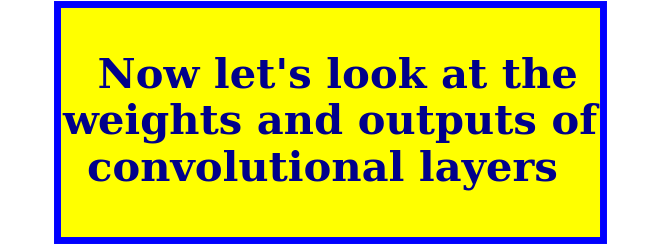

In [85]:
banner.next_topic()

# Now let's look at the weights and outputs of convolutional layers

In [35]:
nnet.device

'cuda'

In [36]:
Xtest[0].shape

(784,)

In [37]:
X = Xtest[0].reshape(1, 28, 28)
T = Ttest[0]
Zs = nnet.use(X, keep_all_outputs=True)
len(Zs)

1

In [38]:
len(nnet.Zs)

5

In [39]:
Ws = list(nnet.parameters())
len(Ws)

8

In [40]:
[W.shape for W in Ws]

[torch.Size([40, 1, 4, 4]),
 torch.Size([40]),
 torch.Size([10, 40, 3, 3]),
 torch.Size([10]),
 torch.Size([20, 1440]),
 torch.Size([20]),
 torch.Size([10, 20]),
 torch.Size([10])]

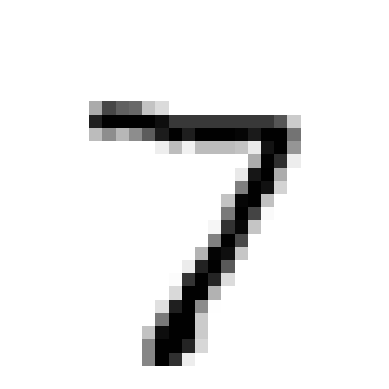

In [41]:
plt.imshow(-X.squeeze(), cmap='gray')
plt.axis('off');

In [42]:
W_layer1 = list(nnet.parameters())[0]
W_layer1.shape

torch.Size([40, 1, 4, 4])

In [43]:
len(nnet.Zs)

5

In [44]:
[Z.shape for Z in nnet.Zs]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 40, 25, 25]),
 torch.Size([1, 1440]),
 torch.Size([1, 20]),
 torch.Size([1, 10])]

In [45]:
n_units_layer_1 = 40

In [46]:
Z_layer1 = nnet.Zs[1]
Z_layer1.shape

torch.Size([1, 40, 25, 25])

In [47]:
Z_layer1 = Z_layer1.reshape(40, 25, 25)
Z_layer1.shape

torch.Size([40, 25, 25])

(-0.5, 27.5, 27.5, -0.5)

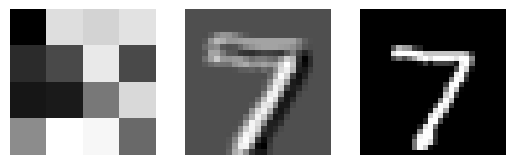

In [48]:
plt.subplot(1, 3, 1)
plt.imshow(W_layer1[0, 0, :, :].detach().cpu(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(Z_layer1[0, :, :].detach().cpu(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(X.squeeze(), cmap='gray')
plt.axis('off')

In [49]:
np.random.randint(10)

1

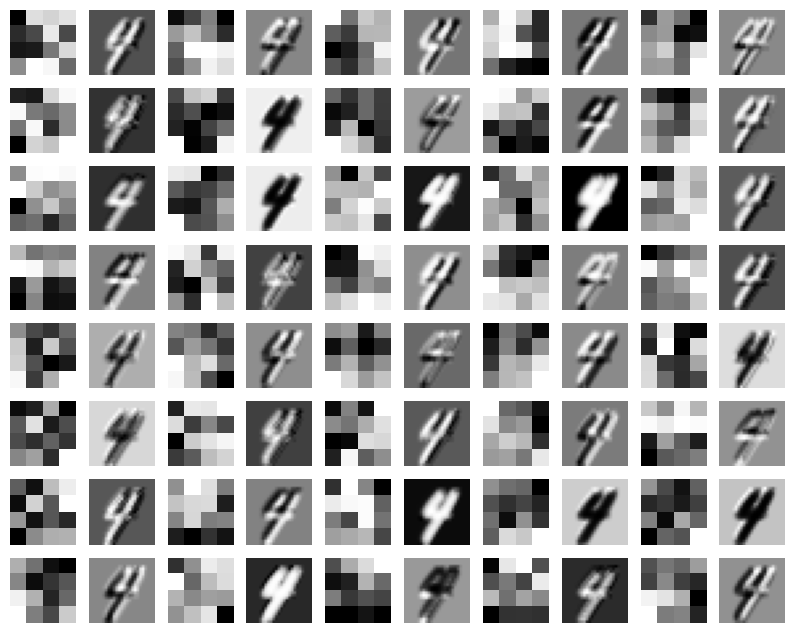

In [56]:
W_layer1 = list(nnet.parameters())[0]

random_digit = np.random.randint(Xtest.shape[0])
X = Xtest[random_digit].reshape(28, 28)    
nnet.use(X, keep_all_outputs=True)
Z_layer1 = nnet.Zs[1].reshape(40, 25, 25)

plt.figure(figsize=(10,10))
ploti = 0
for unit in range(40):
    ploti += 1
    plt.subplot(10, 10, ploti)
    plt.imshow(W_layer1[unit, 0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 10, ploti)
    plt.imshow(Z_layer1[unit, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')

In [57]:
nnet

ConvNet2d(
  (activation_function): Tanh()
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 40, kernel_size=(4, 4), stride=(1, 1))
      (1): Tanh()
    )
    (1): Sequential(
      (0): Conv2d(40, 10, kernel_size=(3, 3), stride=(2, 2))
      (1): Tanh()
    )
  )
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1440, out_features=20, bias=True)
      (1): Tanh()
    )
    (1): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [58]:
[Z.shape for Z in nnet.Zs]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 40, 25, 25]),
 torch.Size([1, 1440]),
 torch.Size([1, 20]),
 torch.Size([1, 10])]

In [59]:
n_units_layer_2 = 10

In [60]:
1440 / n_units_layer_2

144.0

In [61]:
np.sqrt(144)

12.0

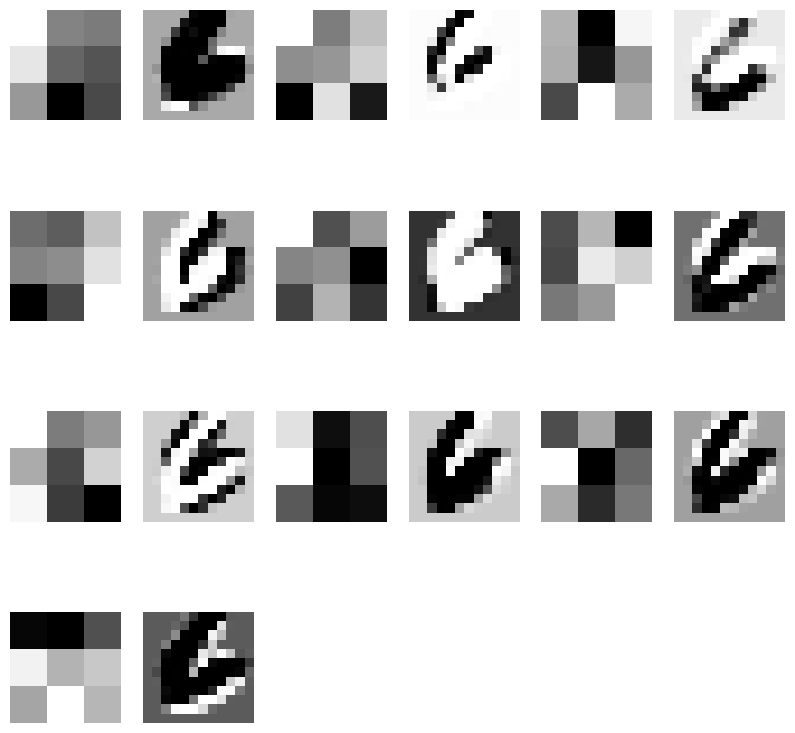

In [66]:
W_layer2 = list(nnet.parameters())[2]  # skip bias weight in layer 1

random_digit = np.random.randint(Xtest.shape[0])
X = Xtest[random_digit].reshape(28, 28)    
nnet.use(X, keep_all_outputs=True)
Z_layer2 = nnet.Zs[2].reshape(n_units_layer_2, 12, 12)
n_units = Z_layer2.shape[0]

plt.figure(figsize=(10,10))
ploti = 0
for unit in range(10):
    ploti += 1
    plt.subplot(4, 6, ploti)
    plt.imshow(W_layer2[unit, 0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(4, 6, ploti)
    plt.imshow(Z_layer2[unit, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')

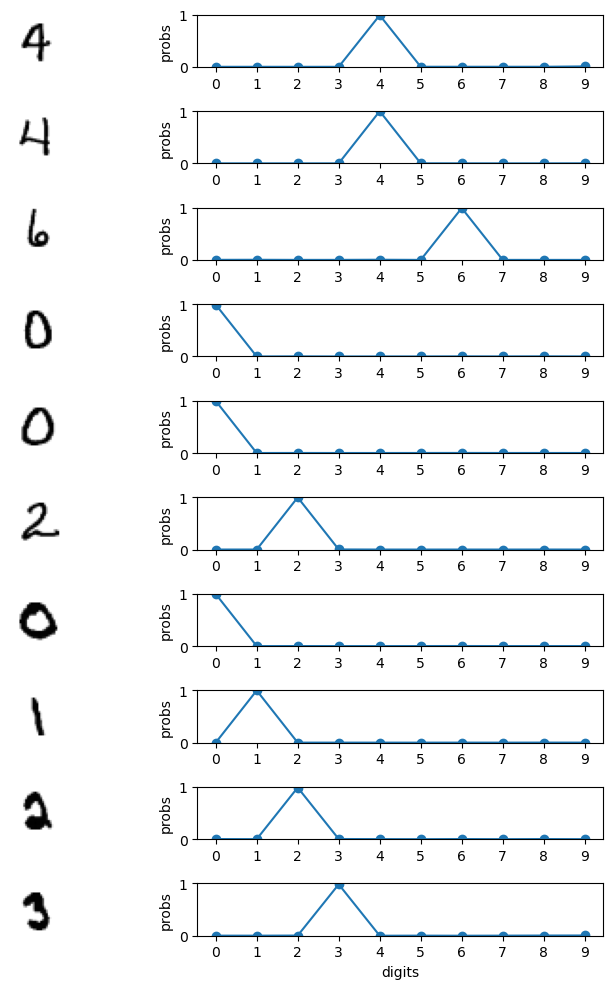

In [70]:
first = np.random.randint(10000 - 20)

Xs = Xtest[first:first + 20].reshape(-1, 1, 28, 28)
classes, probs = nnet.use(Xs, return_probs=True)

plt.figure(figsize=(8, 10))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(-Xs[i, 0, :, :], cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    Yprobs = probs[i, :]
    plt.plot(Yprobs, 'o-')
    plt.ylim(0, 1)
    plt.xticks(range(10))
    plt.ylabel('probs')
    if i == 9:
        plt.xlabel('digits')
plt.tight_layout()